# Moving Average Crossover Trading Strategy

## How It Works

The strategy utilizes two moving averages:

- **Short-term Moving Average ($MA_{\text{short}}$)**: calculated over a smaller window $n_s$ (e.g., 50 days).
- **Long-term Moving Average ($MA_{\text{long}}$)**: calculated over a larger window $n_l > n_s$ (e.g., 200 days).

Formally:
$$
MA_{\text{short}}(t) = \frac{1}{n_s} \sum_{k=0}^{n_s-1} P_{t-k}
$$
$$
MA_{\text{long}}(t) = \frac{1}{n_l} \sum_{k=0}^{n_l-1} P_{t-k}
$$
Where $P_t$ is the closing price at time $t$.

## Trading Signals

- **Buy Signal ("Golden Cross")**: when $MA_{\text{short}}(t)$ crosses above $MA_{\text{long}}(t)$.
- **Sell Signal ("Death Cross")**: when $MA_{\text{short}}(t)$ crosses below $MA_{\text{long}}(t)$.

### Signal Logic in Math

$$
\begin{align*}
\text{Buy Signal:} \quad & MA_{\text{short}}(t-1) \leq MA_{\text{long}}(t-1) \quad \text{and} \quad MA_{\text{short}}(t) > MA_{\text{long}}(t) \\
\text{Sell Signal:} \quad & MA_{\text{short}}(t-1) \geq MA_{\text{long}}(t-1) \quad \text{and} \quad MA_{\text{short}}(t) < MA_{\text{long}}(t)
\end{align*}
$$

## Example Log Decision

Every time a crossover event is detected, print:






Where the signal is either "Golden Cross" (Buy) or "Death Cross" (Sell).

## Considerations

- The window sizes ($n_s$, $n_l$) influence signal frequency and sensitivity.
- Larger $n_l$ smooth out noise but delay signals; smaller $n_s$ reacts faster but can cause false signals.
- Detailed logs for each decision are crucial for debugging and backtesting.
- Works the same on Mac, Windows, Linux; only package installation differs.



![Moving Average Crossover Example](macexample.png)

https://www.youtube.com/watch?v=IvvUbh-cnX4

# Code For a single security

Data columns: MultiIndex([( 'Close', 'SOXL'),
            (  'High', 'SOXL'),
            (   'Low', 'SOXL'),
            (  'Open', 'SOXL'),
            ('Volume', 'SOXL')],
           names=['Price', 'Ticker'])
Data for SOXL downloaded with 250 rows.
Date       | Close   | Short_EMA | Long_EMA | Signal       | Action
---------------------------------------------------------------
2024-09-09 | 27.13 | 25.74 | 25.69 | Golden Cross | BUY
2025-02-25 | 24.91 | 28.75 | 28.76 | Death Cross  | SELL
2025-07-24 | 25.62 | 22.91 | 22.87 | Golden Cross | BUY

Trade Log:
2024-09-09 - BUY at 27.13
2025-02-25 - SELL at 24.91
2025-07-24 - BUY at 25.62


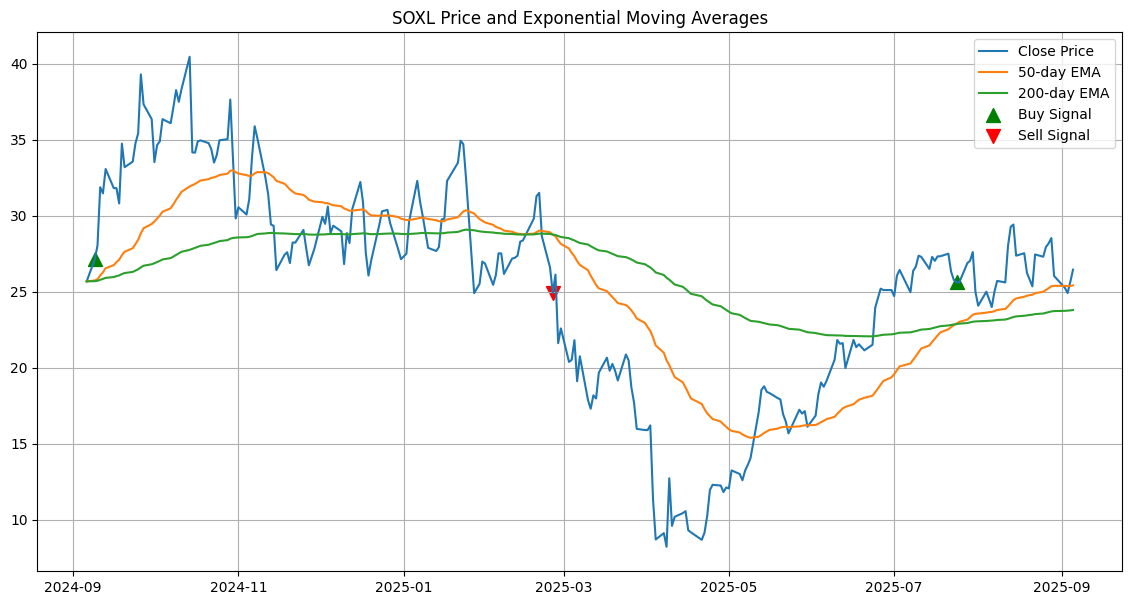


Main Analysis as of 2025-09-06:
You currently hold a position since the last signal was a Golden Cross, which means the short-term (50-day) EMA has crossed above the long-term (200-day) EMA. This is typically a bullish sign suggesting an upward trend. Consider holding or adding to your position while monitoring the trend.


In [19]:
%matplotlib inline

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Parameters
ticker = "SOXL"
short_window = 50
long_window = 200

# Download historical data (last year)
data = yf.download(ticker, period="1y", interval="1d", auto_adjust=True, progress=False)

# Diagnostic: print DataFrame columns to check for duplicates or multi-index
print("Data columns:", data.columns)

if data.empty:
    print(f"No data found for {ticker}. Please check the ticker or data source.")
else:
    print(f"Data for {ticker} downloaded with {len(data)} rows.")

    # Calculate Exponential Moving Averages (EMA)
    data['Short_EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['Long_EMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()

    in_position = False
    trades = []

    print("Date       | Close   | Short_EMA | Long_EMA | Signal       | Action")
    print("---------------------------------------------------------------")

    for i in range(1, len(data)):
        row = data.iloc[i]
        prev = data.iloc[i - 1]
        date = row.name.date()

        # Safely get single scalar values if they are Series
        def safe_scalar(val):
            if isinstance(val, pd.Series):
                return val.iloc[0]
            return val

        short_ema = safe_scalar(row['Short_EMA'])
        long_ema = safe_scalar(row['Long_EMA'])
        prev_short_ema = safe_scalar(prev['Short_EMA'])
        prev_long_ema = safe_scalar(prev['Long_EMA'])
        close_price = safe_scalar(row['Close'])

        action = ""

        if pd.notna(short_ema) and pd.notna(long_ema):
            if float(short_ema) > float(long_ema) and float(prev_short_ema) <= float(prev_long_ema):
                action = "BUY"
                in_position = True
                print(f"{date} | {float(close_price):.2f} | {float(short_ema):.2f} | {float(long_ema):.2f} | Golden Cross | {action}")
                trades.append({'date': row.name, 'type': 'BUY', 'price': float(close_price)})

            elif float(short_ema) < float(long_ema) and float(prev_short_ema) >= float(prev_long_ema):
                if in_position:
                    action = "SELL"
                    in_position = False
                    print(f"{date} | {float(close_price):.2f} | {float(short_ema):.2f} | {float(long_ema):.2f} | Death Cross  | {action}")
                    trades.append({'date': row.name, 'type': 'SELL', 'price': float(close_price)})

    print("\nTrade Log:")
    for t in trades:
        print(f"{t['date'].date()} - {t['type']} at {t['price']:.2f}")

    # Plot the price and EMAs
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['Short_EMA'], label=f'{short_window}-day EMA')
    plt.plot(data['Long_EMA'], label=f'{long_window}-day EMA')

    buy_dates = [t['date'] for t in trades if t['type'] == 'BUY']
    buy_prices = [t['price'] for t in trades if t['type'] == 'BUY']
    sell_dates = [t['date'] for t in trades if t['type'] == 'SELL']
    sell_prices = [t['price'] for t in trades if t['type'] == 'SELL']

    plt.scatter(buy_dates, buy_prices, marker='^', color='green', s=100, label='Buy Signal')
    plt.scatter(sell_dates, sell_prices, marker='v', color='red', s=100, label='Sell Signal')

    plt.title(f"{ticker} Price and Exponential Moving Averages")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Main analysis and detailed recommendation for today
    today = datetime.datetime.today().date()
    if trades:
        last_trade = trades[-1]
        if last_trade['type'] == 'BUY':
            recommendation = ("You currently hold a position since the last signal was a Golden Cross, "
                              "which means the short-term (50-day) EMA has crossed above the long-term (200-day) EMA. "
                              "This is typically a bullish sign suggesting an upward trend. "
                              "Consider holding or adding to your position while monitoring the trend.")
        else:
            recommendation = ("You are currently out of the market since the last signal was a Death Cross, "
                              "indicating the short-term EMA has crossed below the long-term EMA. "
                              "This is generally considered a bearish indicator suggesting downward momentum. "
                              "Consider waiting before entering a new position or look for new buy signals.")
    else:
        recommendation = ("No trades have been executed yet. Watch the EMAs for crossover signals. "
                          "A Golden Cross signals a buy opportunity, while a Death Cross signals a potential exit.")

    print(f"\nMain Analysis as of {today}:")
    print(recommendation)
